In [98]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [37]:
import os
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from tslearn.clustering import TimeSeriesKMeans

from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import yt
import matplotlib.pyplot as plt 

# yt data read

In [6]:
# read the data into yt
modelname = 'wUS-SH-2010_percent.nc'
fi = os.path.join(os.environ.get('geoSamplerDataDir'), modelname)

latrng=None
lonrng=None
    
with xr.open_dataset(fi) as xr_ds:
    dvs = xr_ds.dvs.to_masked_array().data
    depth = xr_ds.depth.to_masked_array().data    
    
    lon = xr_ds.longitude 
    
    if latrng:        
        latmask = (xr_ds.latitude >= latrng[0]) & (xr_ds.latitude <= latrng[1])
        dvs  = dvs[:,latmask,:]     
        latvals = xr_ds.latitude[latmask]
    else:
        latvals = xr_ds.latitude
        latrng=[latvals.data.min(), latvals.data.max()]
        
    if lonrng:    
        lonmask = (lon >= lonrng[0]) & (lon <= lonrng[1])
        dvs = dvs[:,:,lonmask]            
        lonvals = xr_ds.longitude[lonmask]
    else:
        lonvals = xr_ds.longitude
        lonrng=[lonvals.data.min(), lonvals.data.max()]
        
                  
    deprng = [xr_ds.depth.data.min(), xr_ds.depth.data.max()]
    
data = {
    'dvs': (dvs, "%")
}
bbox = np.array([
  deprng,   
  latrng,
  lonrng
])

dims = ['depth', 'latitude', 'longitude']

In [7]:
ds = yt.load_uniform_grid(data, data['dvs'][0].shape, 1.0, geometry=("internal_geographic", dims),
bbox=bbox)

yt : [INFO     ] 2021-07-23 09:02:25,978 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-07-23 09:02:25,979 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2021-07-23 09:02:25,979 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2021-07-23 09:02:25,980 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2021-07-23 09:02:25,980 Parameters: cosmological_simulation   = 0


# clustering 

In [43]:
def get_data(fi, deprng=None, latrng=None, lonrng=None):
    with xr.open_dataset(fi) as xr_ds:
        dvs = xr_ds.dvs.to_masked_array().data
        depth = xr_ds.depth.to_masked_array().data    
        longitude = xr_ds.longitude.to_masked_array().data
        latitude = xr_ds.latitude.to_masked_array().data
        
        dims = [depth, longitude, latitude]
        limiters = [deprng, lonrng, latrng]
        newdims = []
        
        for dimind, dim, rng in zip([0,1,2], dims, limiters):
            if rng:
                msk = (dim >= rng[0]) & (dim <= rng[1])
                if dimind == 0:
                    dvs = dvs[msk, :, :]
                elif dimind == 1:
                    dvs = dvs[:, msk :]
                elif dimind == 2:
                    dvs = dvs[:, :, msk]
                newdims.append(dim[msk])
            else:
                newdims.append(dim)
                
    
    return dvs, newdims[0], newdims[1], newdims[2]

dvs, depth, lon, lat = get_data(fi, deprng=[60., 410.], latrng=None, lonrng=None)


# reshape for kmeans
dvsN = dvs.reshape((depth.size, lat.size*lon.size)).T 
dvsN.shape


(11346, 10)

In [58]:
model_3 = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=10)
model_3.fit(dvsN)
labels_3 = model_3.labels_.reshape((lat.size, lon.size))

In [59]:
model = TimeSeriesKMeans(n_clusters=10, metric="euclidean", max_iter=10)
model.fit(dvsN)
labels = model_3.labels_.reshape((lat.size, lon.size))

# plotting

yt : [INFO     ] 2021-07-23 11:09:23,258 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-07-23 11:09:23,264 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-07-23 11:09:23,265 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-07-23 11:09:23,269 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-07-23 11:09:23,271 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-07-23 11:09:23,275 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-07-23 11:09:23,336 Plotting ('stream', 'dvs'): Both positive and negative values. Min = -14.010000228883365 %, Max = 8.819999694825182 %.
yt : [WARNING  ] 2021-07-23 11:09:23,337 Switching to symlog colorbar scaling.
yt : [INFO     ] 2021-07-23 11:09:32,115 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-07-23 11:09:32,117 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-07-23 11:09:32,118 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-07-23 11:09:32,1


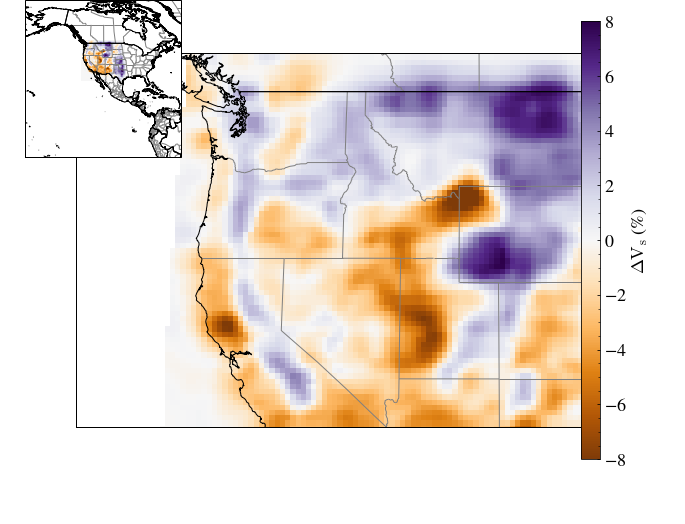

yt : [INFO     ] 2021-07-23 11:09:41,733 Saving plot map_w_kmeans_velo.png


['map_w_kmeans_velo.png']

In [123]:
c = ds.domain_center
c[0] = 100.  # the depth!

# zoom_extents = (-130, -95, 22, 52) # whole W us zoom
zoom_extents = (-130, -105, 35, 50) # W us focus zoom 
full_map_extents = (c[2].value-50, c[2].value+50, -10, 70)


def get_slice():
    p = yt.SlicePlot(ds, "depth", 'dvs',center=c)
    p.set_mpl_projection(('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} ))
    p.set_log('dvs',False)
    p.set_zlim('dvs',-8, 8)
    p.set_cmap('dvs','PuOr')
    return p

def add_features(carto_ax):
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_1_states_provinces_lines', '10m',
        edgecolor='gray', facecolor='none'))
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_countries', '10m',
            edgecolor='black', facecolor='none'))    

     
def add_zoombox_outline(carto_ax, zoom_extents, **plot_kwargs):
    # adds a box to a cartopy GeoAxes, for outlining the extents of the zoomed region
    xlocs = [zoom_extents[0], zoom_extents[1], zoom_extents[1], 
             zoom_extents[0], zoom_extents[0]]
    ylocs = [zoom_extents[2], zoom_extents[2], zoom_extents[3],
             zoom_extents[3], zoom_extents[2] ]
    carto_ax.plot(xlocs, ylocs, transform=ccrs.PlateCarree(), **plot_kwargs)
    
    
# initialize our slice plot to the zoomed-in view
p = get_slice()
p.set_colorbar_label('dvs',"$\Delta\mathrm{V_s}$ (%)")
p._setup_plots()
p.plots["dvs"].axes.set_extent(zoom_extents)
add_features(p.plots["dvs"].axes)

proj = p.plots["dvs"].axes.projection


# add a small child axis with the same projection
locator_box = [0.0, 0.7, 0.3, 0.3]
ax2 = p.plots["dvs"].figure.add_axes(locator_box, projection=proj)

# get a new slice, covering the whole domain and adjust the axes and 
# figure references the child axis and existing figure
p2 = get_slice()
p2.plots["dvs"].axes = ax2
p2.plots["dvs"].figure = p.plots["dvs"].figure
p2.plots["dvs"].hide_colorbar()

# add our features 
p2._setup_plots()
add_features(ax2)
p2.plots["dvs"].axes.set_extent(full_map_extents)

# the child axes position gets reset somewhere, so set it again here
ax2.set_position(locator_box)

p.show()
p.save("map_w_kmeans_velo.png")


# # the other fig

# fig = plt.figure(figsize=(5,9)) 

# axs = [plt.subplot(2,1,i+1, projection=ccrs.Robinson(central_longitude = float(c[2].value), globe=None )) for i in range(2)]

# for ax in axs:

#     ax.add_feature(cfeature.NaturalEarthFeature(
#         'cultural', 'admin_1_states_provinces_lines', '10m',
#         edgecolor='gray', facecolor='none'))
#     ax.add_feature(cfeature.NaturalEarthFeature(
#         'cultural', 'admin_0_countries', '10m',
#         edgecolor='black', facecolor='none'))

# cmapstr0 = "tab20b"
# cmapstr = "tab20c"
# axs[0].pcolormesh(lon, lat, labels_3, cmap=cmapstr0, transform=ccrs.PlateCarree())
# axs[0].set_title('profile classifications, N  = 3')
# axs[1].pcolormesh(lon, lat, labels, cmap=cmapstr, transform=ccrs.PlateCarree())
# axs[1].set_title('profile classifications, N  = 10')
# fig.savefig("map_w_kmeans_profiles.png")
# plt.show()






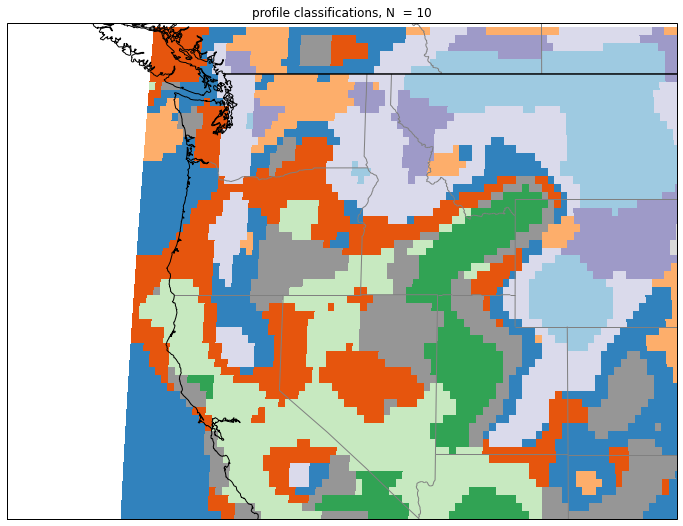

In [137]:
fig3 = plt.figure(figsize=(12,12)) 
ax = plt.axes(projection=ccrs.Robinson(central_longitude = float(c[2].value), globe=None ))

ax.add_feature(cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '10m',
    edgecolor='gray', facecolor='none'))
ax.add_feature(cfeature.NaturalEarthFeature(
    'cultural', 'admin_0_countries', '10m',
    edgecolor='black', facecolor='none'))
ax.set_extent(zoom_extents)
cmapstr = "tab20c"
pc = ax.pcolormesh(lon, lat, labels, cmap=cmapstr, transform=ccrs.PlateCarree())
# plt.colorbar(mappable=pc, ax=ax)
ax.set_title('profile classifications, N  = 10')
fig3.savefig("map_w_kmeans_profiles_N10.png")
plt.show()

In [128]:
plt.colorbar?

Signature: plt.colorbar(mappable=None, cax=None, ax=None, **kw)
Docstring:
Add a colorbar to a plot.

Function signatures for the :mod:`~matplotlib.pyplot` interface; all
but the first are also method signatures for the
:meth:`~matplotlib.figure.Figure.colorbar` method::

  colorbar(**kwargs)
  colorbar(mappable, **kwargs)
  colorbar(mappable, cax=cax, **kwargs)
  colorbar(mappable, ax=ax, **kwargs)

Parameters
----------
mappable
    The `matplotlib.cm.ScalarMappable` (i.e., `~matplotlib.image.Image`,
    `~matplotlib.contour.ContourSet`, etc.) described by this colorbar.
    This argument is mandatory for the `.Figure.colorbar` method but optional
    for the `.pyplot.colorbar` function, which sets the default to the current
    image.

    Note that one can create a `ScalarMappable` "on-the-fly" to generate
    colorbars not attached to a previously drawn artist, e.g. ::

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

cax : :class:`~matplotlib.axes.Axes` objec